Install and Import the required libraries

In [ ]:
from google.colab import drive, files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # matplotlib.pyplot plots data
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

from zipfile import ZipFile
import os, math, sys, cv2
from matplotlib.patches import Rectangle

!pip install -q pydicom
import pydicom as dcm
from tqdm import tqdm_notebook

!pip install keras==2.2.5
%tensorflow_version 1.x

!pip install h5py==2.10.0
!pip install wandb 
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.9MB 14.5MB/s 
     |████████████████████████████████| 337kB 13.7MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
TensorFlow 1.x selected.
     |████████████████████████████████| 2.9MB 13.4MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 1.8MB 14.1MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 174kB 54.4MB/s 
     |████████████████████████████████| 133kB 53.9MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=2d0d79e89e35d0b2bc955e88598be6ca9e112518c639746a321635a015fa5f8b
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd9

Download the dataset from Kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c rsna-pneumonia-detection-challenge

     |████████████████████████████████| 61kB 6.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=6f76e1f796e57aee6646573116398fca87c4ba296c7c3d42a756b260f5563f23
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json
100% 3.65G/3.66G [00:54<00:00, 71.3MB/s]
100% 3.66G/3.66G [00:54<00:00, 72.0MB/s]


In [ ]:
file_name = 'rsna-pneumonia-detection-challenge.zip'
datafile = ZipFile(file_name, 'r')
datafile.extractall()

In [ ]:
data_folder = '/content/'

train_labels = pd.read_csv(data_folder + 'stage_2_train_labels.csv')
class_info = pd.read_csv(data_folder +'stage_2_detailed_class_info.csv')

print(f'Train Labels has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Train Labels # of patientID duplicates: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Class Info # of patientID duplicates: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

Train Labels has 30227 rows and 6 columns
Class info has 30227 rows and 2 columns
Train Labels # of patientID duplicates: 3543
Class Info # of patientID duplicates: 3543


Printing the first few rows of "Train Labels" and "Class Info"

In [ ]:
print('Train labels :\n'); display(train_labels.head(10))
print('\nClass info :\n'); display(class_info.head(10))

Train labels :



,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1



Class info :



,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


Checking for nulls in bounding boxes and value counts for targets

In [ ]:
print('Checking nulls in bounding boxes columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Checking value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Checking nulls in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Checking value counts for the targets: {0: 20672, 1: 9555}


Checking  distribution of 'Target' and 'Class' columns

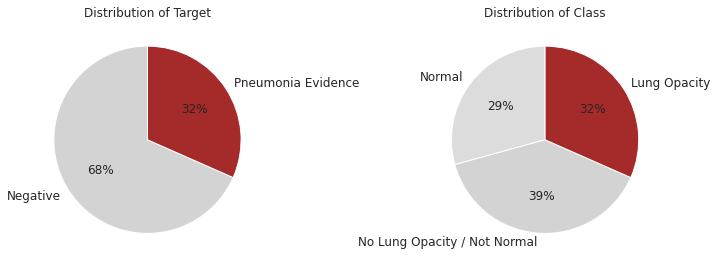

In [ ]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'brown'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

Grouping by patient and checking number of bounding boxes for every unique patient

In [ ]:
bounding_boxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bounding_boxes, on = 'patientId', how = 'left')
print('Number of unique patient ids: {}'.format(len(bounding_boxes)))
print('\nNumber of patient ids per bounding boxes')
(bounding_boxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patient_ids_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

Number of unique patient ids: 26684

Number of patient ids per bounding boxes


,number_of_patient_ids_per_boxes
number_of_boxes,
1,23286
2,3266
3,119
4,13


Let's check how each patientId is mapped to the class type

In [ ]:
print('Each patient Id is associated with {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

Each patient Id is associated with 1 class


Merging "Train Labels" and "Class Info"

In [ ]:
train_class = pd.concat([train_labels, class_info['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class.shape))

Shape of the dataset after the merge: (30227, 8)


Analysis based on reading of images

In [ ]:
train_imgs = os.path.join(data_folder + 'stage_2_train_images/')
test_imgs = os.path.join(data_folder + 'stage_2_test_images/')

sample_patient_id = train_labels['patientId'][0]
dcm_file = train_imgs + '{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

We will read the training images file names and path, determine the total number of images and observe the features of this data set

In [ ]:
from glob import glob
images = pd.DataFrame({'path': glob(os.path.join(train_imgs, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('There are ',images.shape[0],'images in the training folder')
print('The columns ',list(images.columns),'are present in the training images dataframe')
assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

There are  26684 images in the training folder
The columns  ['path', 'patientId'] are present in the training images dataframe


Let us merge the image dataframe that we read just now and the 'Train Class' dataframe read earlier, using 'Patient Id' as the key 

In [ ]:
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class.shape))
del images

Shape of the `train_class` dataframe after merge: (30227, 9)


Get features from the training images and save the feature engineered dataframe for future use

In [ ]:
# Helper function to get additional features from dicom images
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = dcm.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality


In [ ]:
print('Get features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
get_tags(train_class, train_imgs)

Get features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
out_dir = os.path.join('./output/')
if not os.path.exists(out_dir): os.makedirs(out_dir)

train_class.to_pickle('./output/train_feature_engineered.pkl')

Let us load the consolidated data set and observe its shape

In [ ]:
train_class = pd.read_pickle('./output/train_feature_engineered.pkl')
train_class.shape

(30227, 14)

In [ ]:
train_class.head()

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/0004cfab-14fd-4e...,F,51.0,CHEST,PA,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/00313ee0-9eaa-42...,F,48.0,CHEST,PA,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/00322d4d-1c29-49...,M,19.0,CHEST,AP,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/stage_2_train_images/003d8fa0-6bf1-40...,M,28.0,CHEST,PA,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/stage_2_train_images/00436515-870c-4b...,F,32.0,CHEST,AP,CR


In [ ]:
print('Unique `Body Parts Examined`: {}'.format(train_class['BodyPartExamined'].unique()[0]))
print('Unique `Modality`: {}'.format(train_class['Modality'].unique()[0]));

Unique `Body Parts Examined`: CHEST
Unique `Modality`: CR


Let us observe the distribution of `ViewPosition` when Target is 1
The distribution is almost the same, but where there's a Pneumonia Evidence `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior

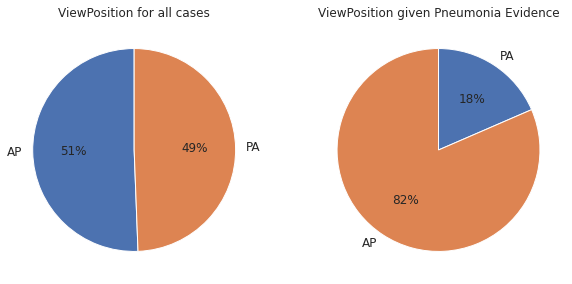

In [ ]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'ViewPosition for all cases', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'ViewPosition given Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

Plot x and y centers of bounding boxes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


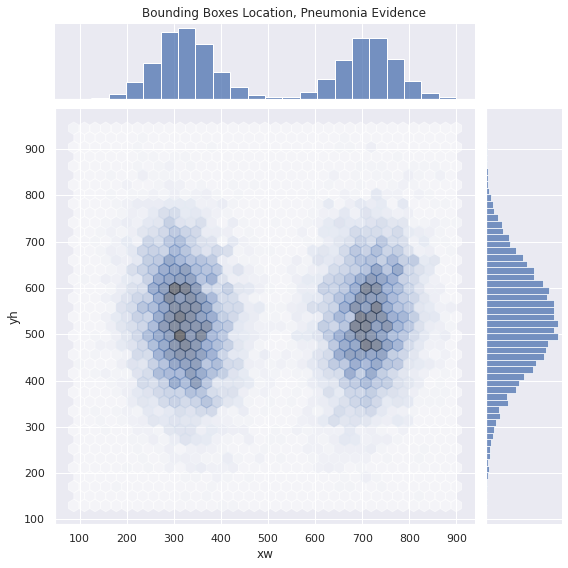

In [ ]:
# Creating a dataframe with columns for center of the rectangles
bounding_boxes = train_class[train_class['Target'] == 1]
bounding_boxes['xw'] = bounding_boxes['x'] + bounding_boxes['width'] / 2
bounding_boxes['yh'] = bounding_boxes['y'] + bounding_boxes['height'] / 2

g = sns.jointplot(x = bounding_boxes['xw'], y = bounding_boxes['yh'], data = bounding_boxes, 
                  kind = 'hex', alpha = 0.5, height = 8)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

Let us explore the bounding boxes centers for ViewPositions for a random sample

In [ ]:
def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

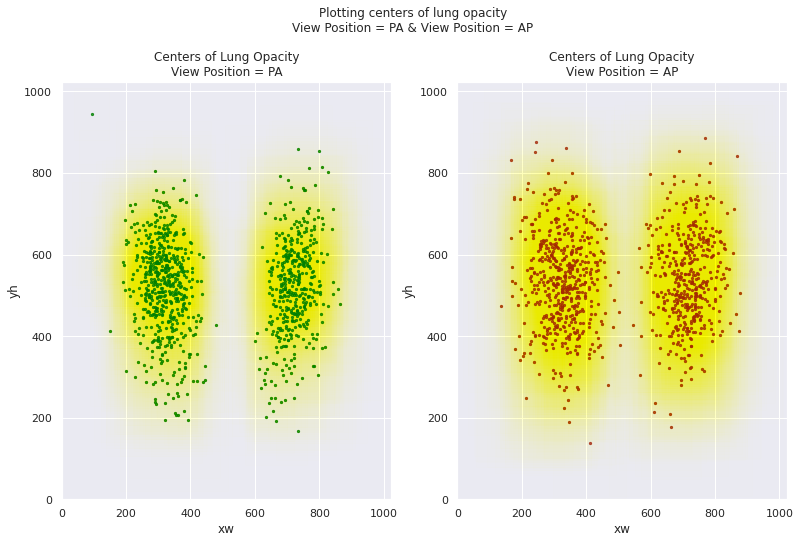

In [ ]:
df1 = bounding_boxes[bounding_boxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bounding_boxes[bounding_boxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

Let us analyze the distribution of Patients' age and check for outliers

Minimum age: 1.0
Maximum age: 155.0
75th Percentile : 59.0
Age in upper whisker for box plot: 84.0



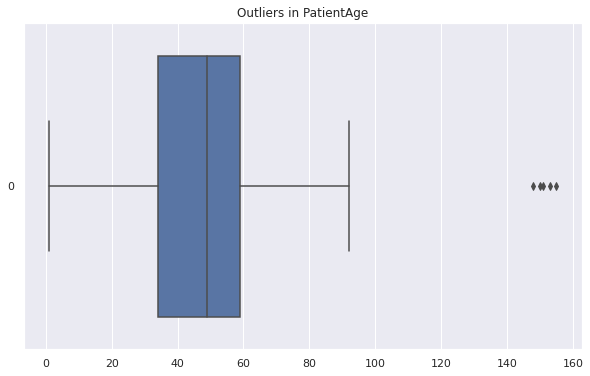

In [ ]:
print('Minimum age: {}'.format(train_class['PatientAge'].min()))
print('Maximum age: {}'.format(train_class['PatientAge'].max()))
print('75th Percentile : {}'.format(train_class['PatientAge'].quantile(0.75)))
print('Age in upper whisker for box plot: {}'.format(train_class['PatientAge'].quantile(0.75) + (train_class['PatientAge'].quantile(0.75) - train_class['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

We can make use of pd.clip() to trim value to a specified lower and upper threshold. So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [ ]:
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int64

Let us get the distribution of PatientAge overall and where there is evidence of Pneumonia

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


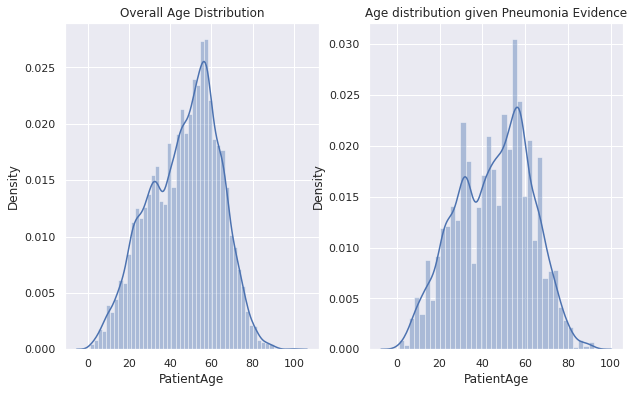

In [ ]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Overall Age Distribution'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Age distribution given Pneumonia Evidence'))



```
# This is formatted as code
```

Let us bin Age values into discrete intervals, used when the need is to segment and sort data values into bins. This takes the Age from a continuous variable to a categorical variable.

In [ ]:
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class['AgeBins'].value_counts()

<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

Let's observe the Value counts of the binned Ages

,"Counts of Age Bins, Overall","Counts of Age Bins, Target=1"
<=26,3972,1478
<=50,12157,3917
<=75,13318,3895
<=100,780,265


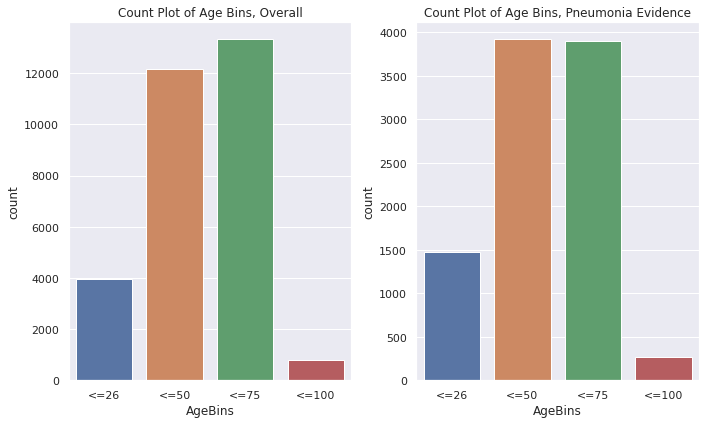

In [ ]:
display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

We will explore the bounding boxes centers for AgeBins for a random sample

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


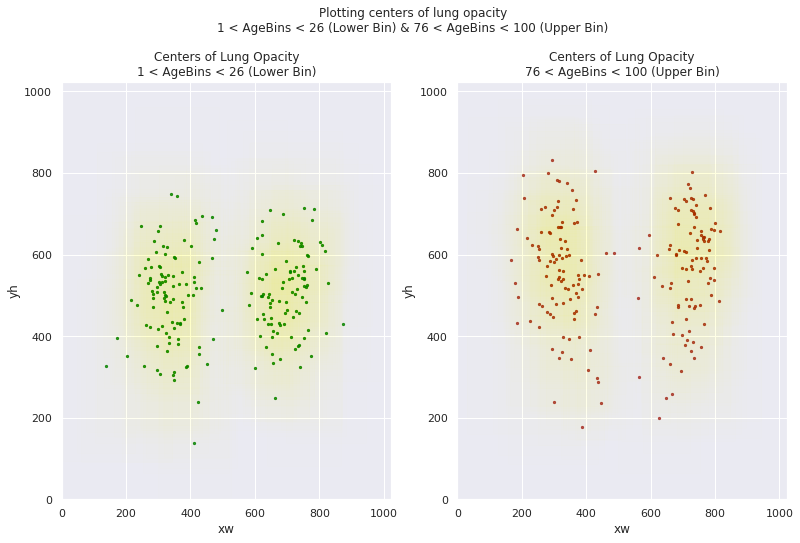

In [ ]:
# Creating a dataframe with columns for center of the rectangles
bounding_boxes = train_class[train_class['Target'] == 1]
bounding_boxes['xw'] = bounding_boxes['x'] + bounding_boxes['width'] / 2
bounding_boxes['yh'] = bounding_boxes['y'] + bounding_boxes['height'] / 2

df1 = bounding_boxes[bounding_boxes['AgeBins'] == '<=26'].sample(200)
df2 = bounding_boxes[bounding_boxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins < 26 (Lower Bin)', '76 < AgeBins < 100 (Upper Bin)')

Let us check gender-wise distribution for cases with Pneumonia Evidence

,"% Gender, Overall","% Gender, Target=1"
F,0.43,0.42
M,0.57,0.58


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


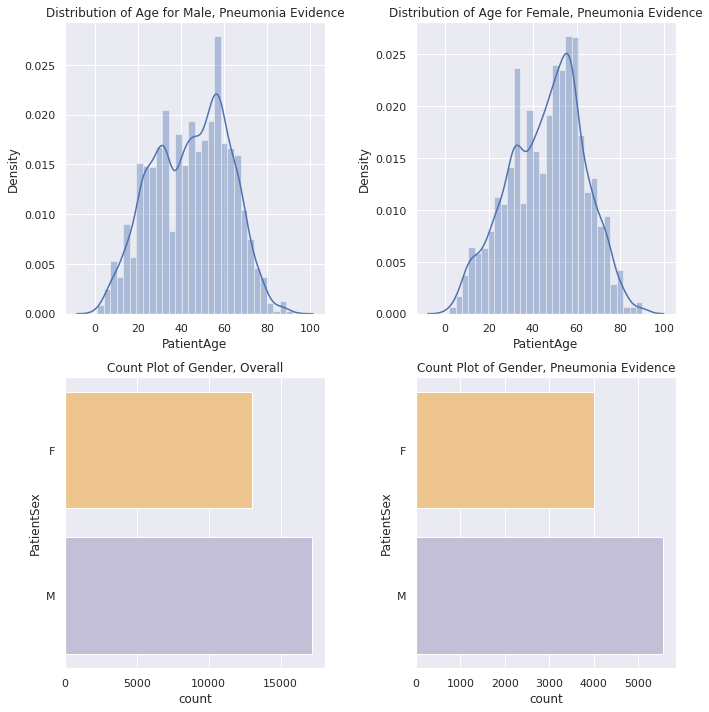

In [ ]:
display(pd.concat([train_class['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class.loc[(train_class['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class.loc[(train_class['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

Let us explore bounding boxes centers for `PatientSex` for a random sample

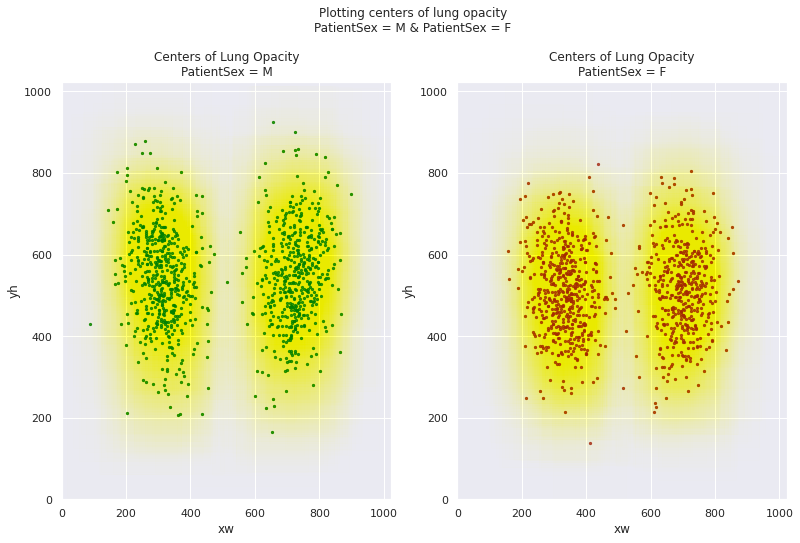

In [ ]:
df1 = bounding_boxes[bounding_boxes['PatientSex'] == 'M'].sample(1000)
df2 = bounding_boxes[bounding_boxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')

In [ ]:
train_class.drop(['BodyPartExamined', 'Modality'], inplace = True, axis = 1)
train_class.to_pickle('./output/train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 13)

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,ViewPosition,AgeBins
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/0004cfab-14fd-4e...,F,51.0,PA,<=75
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/00313ee0-9eaa-42...,F,48.0,PA,<=50
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/stage_2_train_images/00322d4d-1c29-49...,M,19.0,AP,<=26
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/stage_2_train_images/003d8fa0-6bf1-40...,M,28.0,PA,<=50
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/stage_2_train_images/00436515-870c-4b...,F,32.0,AP,<=50


Check some random samples from training data
Checking some random samples as below:

Different classes i.e. Normal, No Lung Opacity / Not Normal and Lung Opacity
Two view positions that we have in the dataset
For the one with Pneumonia Evidence and age = 92
Now, we will make use of custom module (eda) and function (plot_dicom_images) already imported earlier to visualize the images.

Checking sample for different classes


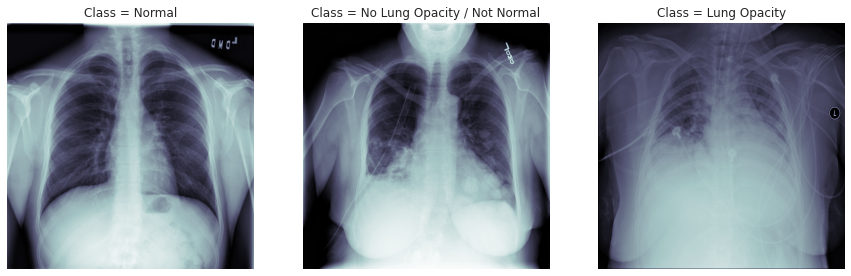

In [ ]:
print('Checking sample for different classes')
sample1 = train_class.loc[train_class['class'] == 'Normal'].iloc[0]
sample2 = train_class.loc[train_class['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class.loc[train_class['class'] == 'Lung Opacity'].iloc[1]
ds1 = dcm.dcmread(sample1['path'])
ds2 = dcm.dcmread(sample2['path'])
ds3 = dcm.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()

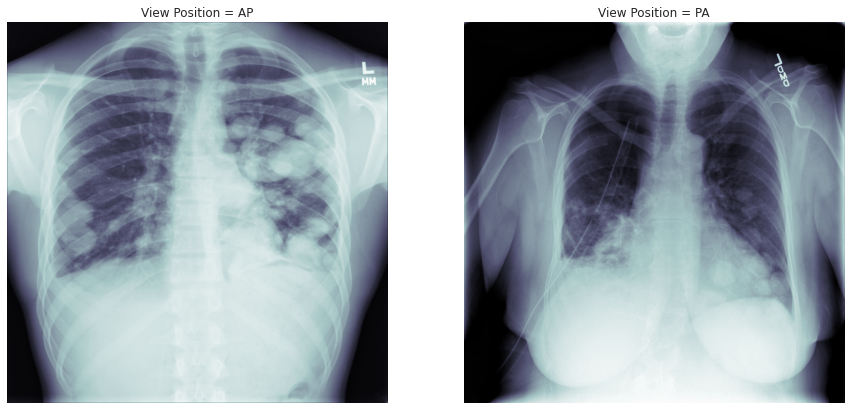

In [ ]:
sample4 = train_class.loc[(train_class['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class.loc[(train_class['ViewPosition'] == 'PA')].iloc[0]
ds4 = dcm.dcmread(sample4['path'])
ds5 = dcm.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

In [ ]:
# Helper function to plot the dicom images
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        path = os.path.join(img_path, image)
        data = dcm.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = dcm.dcmread(path)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'blue', alpha = 0.15)) 
    plt.show()

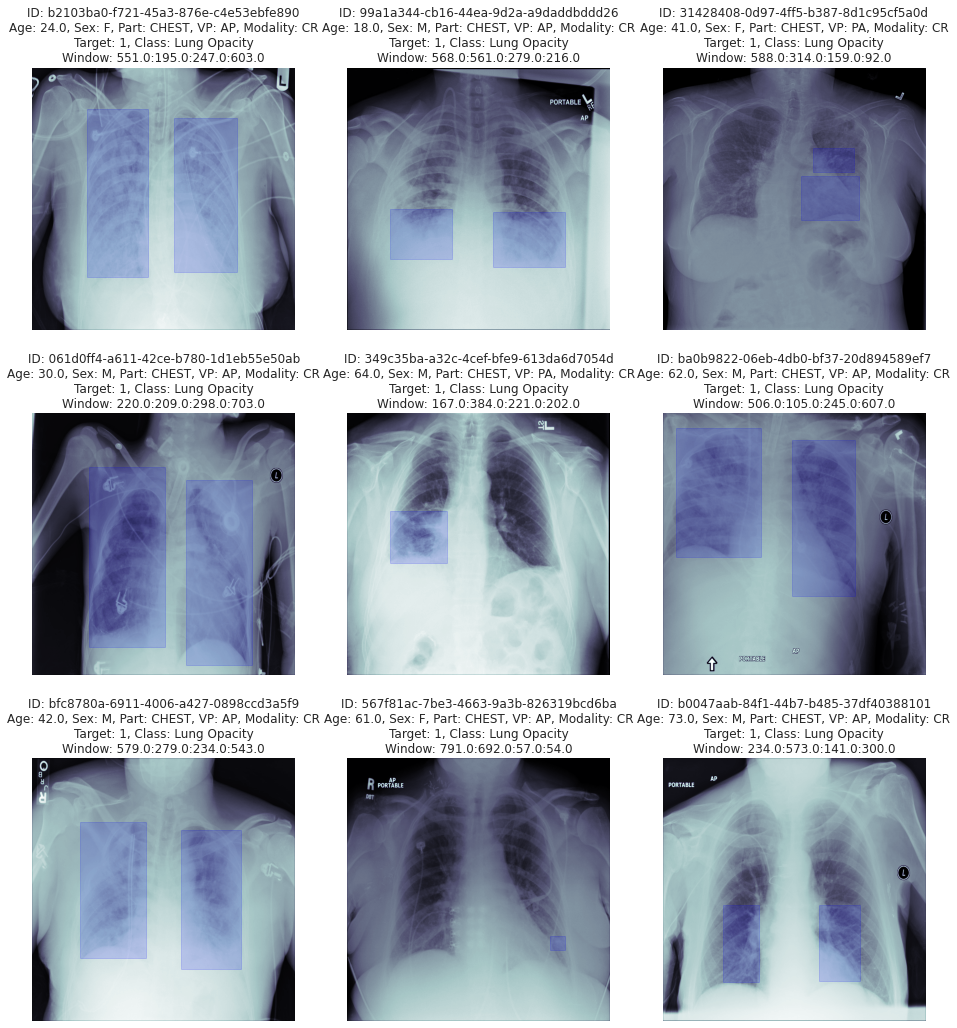

In [ ]:
plot_dicom_images(data = train_class.loc[(train_class['Target'] == 1)].sample(9), 
                  df = train_class, img_path = train_imgs)

## Model Building using Mask R-CNN

In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

Download the Matterport Mask R-CNN implementation with a bit of customization

In [ ]:
if not os.path.exists('/content/'+'Mask_RCNN'):
  !git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('/content/'+'Mask_RCNN')
!git clone https://github.com/madhu367/Capstone_Pneumonia_Detection.git
!mv /content/Mask_RCNN/Capstone_Pneumonia_Detection/model.py ./mrcnn/

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 26.91 MiB/s, done.
Resolving deltas: 100% (562/562), done.
Cloning into 'Capstone_Pneumonia_Detection'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 31 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


Load the COCO Weights to be applied to the Mask R-CNN

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


Import Mask R-CNN libraries

In [ ]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_instances

Using TensorFlow backend.
wandb: WARNING Keras version 2.3.1 is not fully supported. Required keras >= 2.4.0


In [ ]:
# Root directory of the project
mask_rcnn_dir = os.path.join(data_folder+"Mask_RCNN/")
sys.path.append(mask_rcnn_dir)  # To find local version of the library
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(mask_rcnn_dir, "mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(data_folder, "logs")

In [ ]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

Define the Detector configuration parameters that override the default configuration

In [ ]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    #BACKBONE = 'resnet101'

    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 5
    DETECTION_MAX_INSTANCES = 4
    DETECTION_MIN_CONFIDENCE = 0.9  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        4
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

Define the Detector Dataset class

In [ ]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = dcm.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [ ]:
anns = pd.read_csv(os.path.join(data_folder, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Parse the training images and extract the images and annotations

In [ ]:
import glob
image_fps, image_annotations = parse_dataset(train_imgs, anns=anns)

In [ ]:
ds = dcm.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

Split the training and validation data sets with negative sampling to keep the target ditribution consistent between them

In [ ]:
import random
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

#val_size = 1500
# image_fps_val = image_fps_list[:val_size]
# image_fps_train = image_fps_list[val_size:]

#print(len(image_fps_train), len(image_fps_val))

pos = []
neg = []
val_factor = 0.2

for i in range(len(image_annotations)):
  tgt = image_annotations[image_fps_list[i]][0]['Target']
  if (tgt == 1):
    pos.append(image_fps_list[i])
  else:
    neg.append(image_fps_list[i])

n_pos = len(pos)
n_neg = len(neg)

n_pos_train=int((1-val_factor)*n_pos)
n_pos_val = n_pos - n_pos_train

n_neg_train=int((1-val_factor)*n_neg)
n_neg_val = n_neg - n_neg_train

print(n_pos,n_neg)
print(n_pos_train,n_neg_train)
print(n_pos_val,n_neg_val)

image_fps_train_pos = pos[:n_pos_train]
image_fps_train_neg = neg[:n_neg_train]
image_fps_train = image_fps_train_pos+image_fps_train_neg

image_fps_val_pos = pos[:n_pos_val]
image_fps_val_neg = neg[:n_neg_val]
image_fps_val = image_fps_val_pos+image_fps_val_neg

print(len(image_fps_train_pos), len(image_fps_train_neg), len(image_fps_train))
print(len(image_fps_val_pos), len(image_fps_val_neg), len(image_fps_val))

6012 20672
4809 16537
1203 4135
4809 16537 21346
1203 4135 5338


Instantiate the Detector Data set class with the training data set

In [ ]:
# prepare the training dataset
ORIG_SIZE = 1024
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [ ]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    53ab4b73-fe79-4788-b262-cecfb92b6c5f
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 7029, dtype: object]

Instantiate the Detector Data set class with the validation data set

In [ ]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/content/stage_2_train_images/c5fb4095-cb29-4c10-9267-dafb286acc8e.dcm
[1 1]


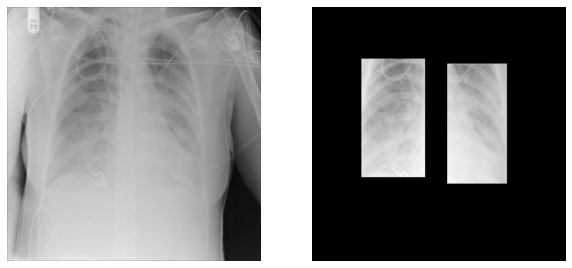

In [ ]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

Image Augmentation function

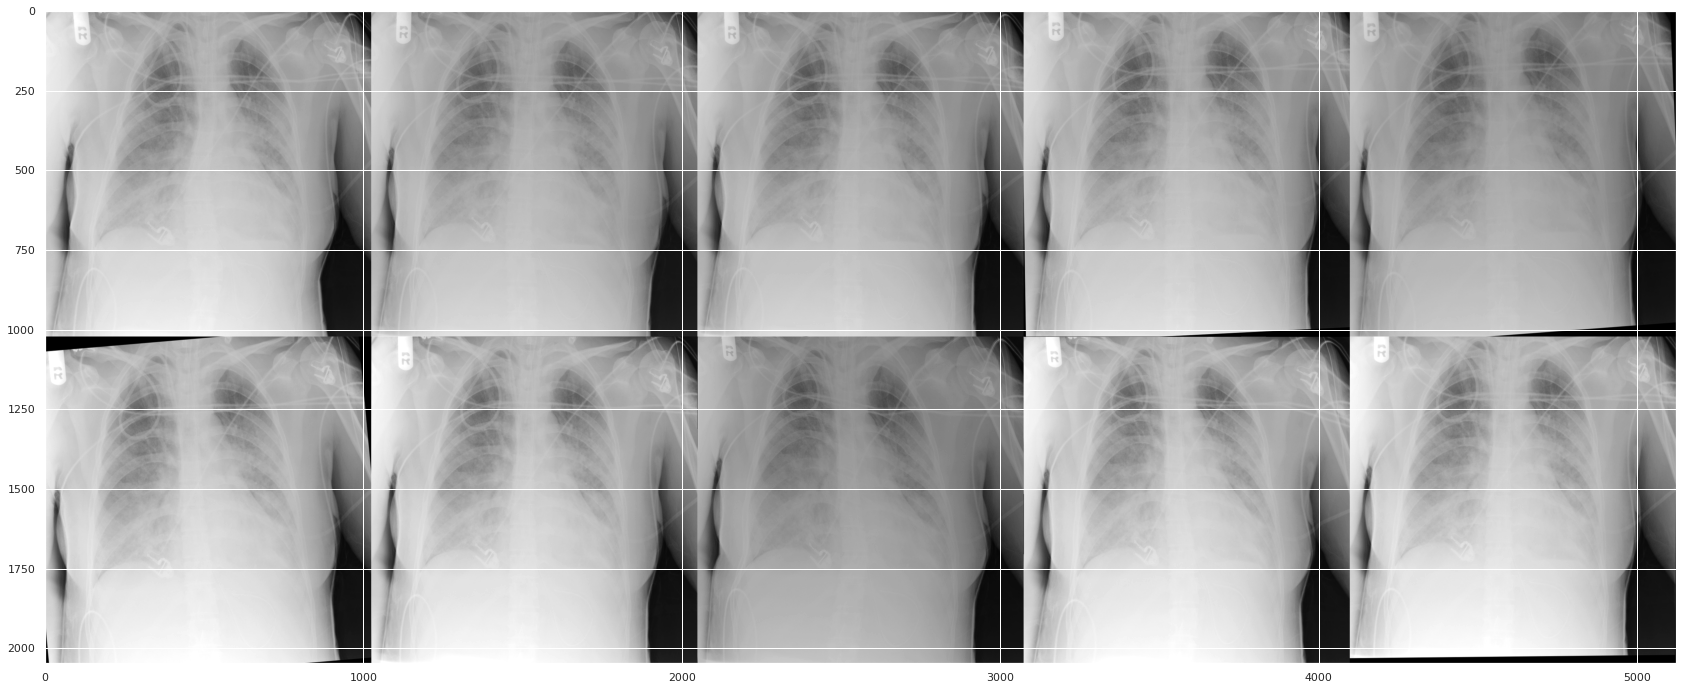

In [ ]:
from imgaug import augmenters as iaa

# Image augmentation 
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.04), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.03, 0.03), "y": (-0.05, 0.05)},
            rotate=(-5, 5),
            shear=(-3, 3),
        ),
        iaa.PiecewiseAffine(scale=(0.002, 0.03)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.85, 1.15)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.12)),
        iaa.Sharpen(alpha=(0.0, 0.12)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

Instantiate the model and load the COCO weights

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=data_folder)

# Exclude the last layers because they require a matching
# number of classes

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


Download the OneCycle libraries for Learning Rate Analysis

In [ ]:
!git clone https://github.com/titu1994/keras-one-cycle.git
!mv '/content/Mask_RCNN/keras-one-cycle' '/content/Mask_RCNN/kerasonecycle'
from kerasonecycle import clr

Cloning into 'keras-one-cycle'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 215 (delta 0), reused 0 (delta 0), pack-reused 211
Receiving objects: 100% (215/215), 3.19 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (82/82), done.


Initialize Weights and Biases for visualization

In [ ]:
hyperparameter_defaults = dict(
    learning_rate=[0.001,0.002,0.005],
    epochs=5,
    )

wandb.init(config=hyperparameter_defaults)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Define the LR callback

In [ ]:
num_samples = len(image_fps_list)
batch_size = 100
minimum_lr = 0.0001
maximum_lr = 0.1

lr_callback = clr.LRFinder(num_samples, batch_size,
                       minimum_lr, maximum_lr,
                       lr_scale='exp', save_dir=DEFAULT_LOGS_DIR)

Train one epoch with LR Callback to find the optimal learning rate

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

LEARNING_RATE = 0.001

model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=1,
            layers='heads',
            augmentation=None,
            custom_callbacks=[lr_callback, WandbCallback()]
            )  

history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/pneumonia20210625T0348/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4        

wandb: ERROR Can't save model, h5py returned error: can't pickle _thread.RLock objects


	LR Finder : Saved the losses and learning rate values in path : {/content/logs}


Plot the Loss vs Learning Rate

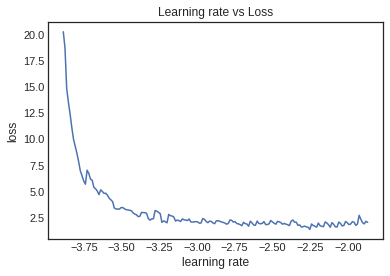

In [ ]:
lr_callback.plot_schedule(clip_beginning=-10,clip_endding=10)

Choose an appropriate Learning rate based on the plot above and define LR Manager callback

In [ ]:
LEARNING_RATE = 0.0005
lr_manager = clr.OneCycleLR(num_samples=num_samples, batch_size=batch_size, max_lr=LEARNING_RATE,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=0.99, minimum_momentum=0.85)

warnings.filterwarnings("ignore")

Train the dataset using the defined LR Manager and WB Callback functions

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=10,
            layers='heads',
            augmentation=augmentation,
            custom_callbacks=[lr_manager,WandbCallback()]
            )

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 1. LR=0.0005

Checkpoint Path: /content/pneumonia20210625T0348/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       

wandb: ERROR Can't save model, h5py returned error: can't pickle _thread.RLock objects


 - lr: 0.00015 - momentum: 0.96 
Epoch 3/10
200/200 [==============================] - 904s 5s/step - loss: 1.5624 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.3856 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.4440 - mrcnn_mask_loss: 0.3933 - val_loss: 1.8519 - val_rpn_class_loss: 0.0381 - val_rpn_bbox_loss: 0.3620 - val_mrcnn_class_loss: 0.2820 - val_mrcnn_bbox_loss: 0.4362 - val_mrcnn_mask_loss: 0.3728
 - lr: 0.00025 - momentum: 0.93 
Epoch 4/10
200/200 [==============================] - 865s 4s/step - loss: 1.5273 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.3712 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.4411 - mrcnn_mask_loss: 0.3990 - val_loss: 1.5170 - val_rpn_class_loss: 0.0392 - val_rpn_bbox_loss: 0.4652 - val_mrcnn_class_loss: 0.2883 - val_mrcnn_bbox_loss: 0.4763 - val_mrcnn_mask_loss: 0.3895
 - lr: 0.00035 - momentum: 0.90 
Epoch 5/10
200/200 [==============================] - 947s 5s/step - loss: 1.5001 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.3759 - mrcnn_class_lo

Reduce the Learning rate further and train for 10 more epochs

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=0.0002,
            epochs=20,
            layers='heads',
            augmentation=augmentation,
            custom_callbacks=[lr_manager,WandbCallback()])

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 10. LR=0.0002

Checkpoint Path: /content/pneumonia20210625T0348/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4      

wandb: ERROR Can't save model, h5py returned error: can't pickle _thread.RLock objects


 - lr: 0.00025 - momentum: 0.93 
Epoch 15/20
200/200 [==============================] - 861s 4s/step - loss: 1.3791 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.3414 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.3748 - val_loss: 1.2548 - val_rpn_class_loss: 0.0309 - val_rpn_bbox_loss: 0.3141 - val_mrcnn_class_loss: 0.2397 - val_mrcnn_bbox_loss: 0.3692 - val_mrcnn_mask_loss: 0.3616
 - lr: 0.00030 - momentum: 0.91 
Epoch 16/20
200/200 [==============================] - 855s 4s/step - loss: 1.3609 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.3331 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.3776 - mrcnn_mask_loss: 0.3791 - val_loss: 1.2923 - val_rpn_class_loss: 0.0295 - val_rpn_bbox_loss: 0.3209 - val_mrcnn_class_loss: 0.2363 - val_mrcnn_bbox_loss: 0.3839 - val_mrcnn_mask_loss: 0.3608
 - lr: 0.00035 - momentum: 0.90 
Epoch 17/20
200/200 [==============================] - 892s 4s/step - loss: 1.3546 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.3233 - mrcnn_class

Display the model performance across epochs

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.942594,0.047492,0.539312,0.326206,0.607261,0.407197,2.065629,0.075683,0.568760,0.369691,0.603937,0.447558
2,1.599654,0.041807,0.377756,0.316377,0.476361,0.392483,1.610719,0.041738,0.394644,0.289674,0.483016,0.401646
3,1.851933,0.038079,0.361970,0.282026,0.436182,0.372799,1.562359,0.040666,0.385558,0.298755,0.444043,0.393336
4,1.516958,0.039201,0.465169,0.288311,0.476305,0.389504,1.527329,0.036695,0.371153,0.279445,0.441060,0.398976
5,1.335943,0.034050,0.363194,0.257719,0.396917,0.369687,1.500130,0.038842,0.375862,0.268280,0.428304,0.388840
6,1.496292,0.035372,0.332919,0.265029,0.421364,0.369053,1.439243,0.034918,0.354137,0.265744,0.402703,0.381740
7,1.470646,0.033276,0.331862,0.250470,0.410913,0.365715,1.418523,0.032624,0.347761,0.256045,0.397811,0.384281
8,1.576307,0.036667,0.415099,0.260617,0.411098,0.374708,1.430777,0.032896,0.341247,0.264445,0.405489,0.386698
9,1.509731,0.033374,0.363134,0.241679,0.421168,0.366891,1.463590,0.033717,0.379296,0.260187,0.403309,0.387079
10,1.890709,0.028249,0.391656,0.258887,0.410304,0.370649,1.455427,0.034136,0.345996,0.269522,0.415372,0.390400


Plot the performance metrics

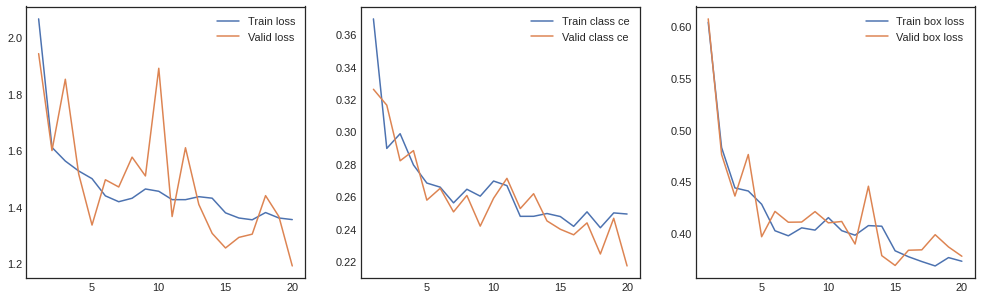

In [ ]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

Determine the best epoch

In [ ]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 20 1.19124174118042


Determine the best model

In [ ]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/pneumonia20210625T0348/mask_rcnn_pneumonia_0020.h5


Load the weights from the best performing model

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=data_folder)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/pneumonia20210625T0348/mask_rcnn_pneumonia_0020.h5
Re-starting from epoch 20


In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

Predict the bounding boxes for few samples in the validation set and visualize them w.r.t the ground truth

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3b90108b50>> (for pre_run_cell):


Exception: ignored


*** No instances to display *** 




*** No instances to display *** 




*** No instances to display *** 




*** No instances to display *** 


*** No instances to display *** 




*** No instances to display *** 




*** No instances to display *** 


*** No instances to display *** 





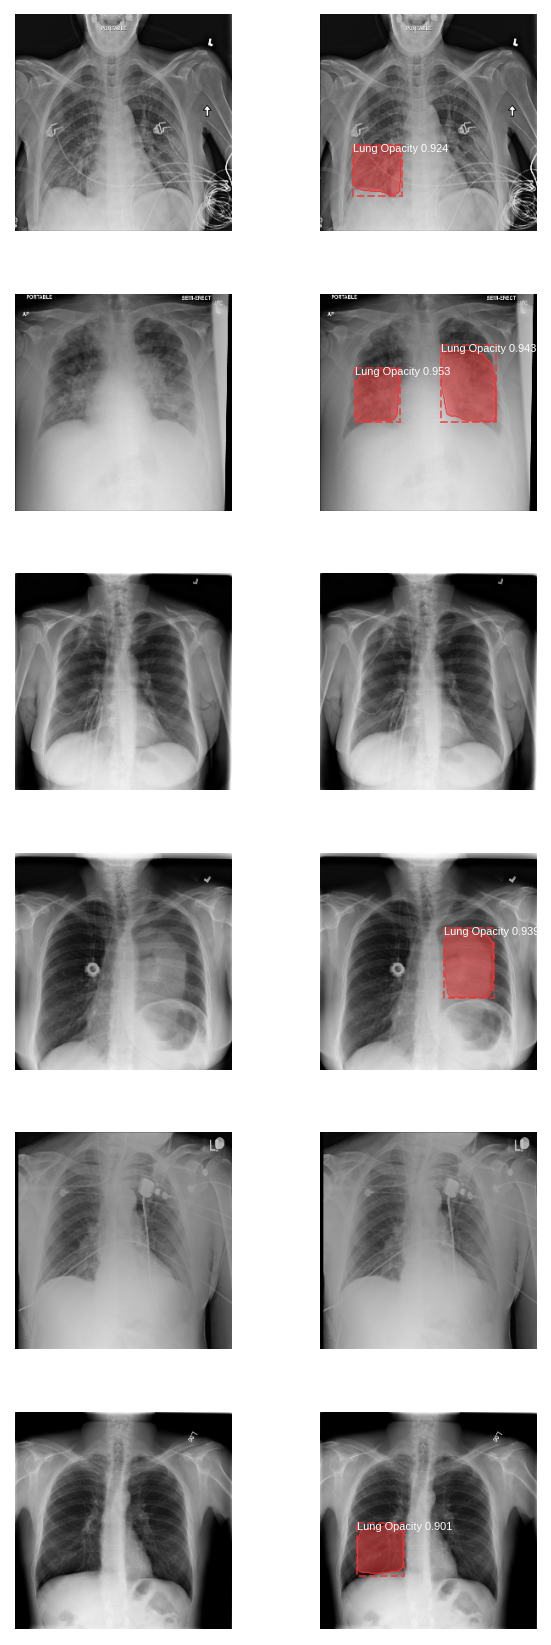

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3b90108b50>> (for post_run_cell):


Exception: ignored

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

ids = [1137,792,697,675,680,831,1065]

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    #image_id = ids[i]

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
   
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]

    pred_bbox = r['rois']
    n_predbox = int(pred_bbox.size/4)
    n_gtbox = int(gt_bbox.size/4)
    
    for p in range(n_predbox):
      for g in range(n_gtbox): 
        iou = get_iou(gt_bbox[g],pred_bbox[p])
        if (iou > 0):
          print('Image Id:',image_id,'***IOU :',round(iou,2))
    print('\n')     

    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])